In [3]:
import os
from lxml import etree
import gensim
#read the corpus
src_file = os.path.join('src/DLUG_Ann_clean.vrt')
tree = etree.parse(src_file)
root = tree.getroot()

In [4]:
## liber year div/chapter,head,p
def check_type(div):
    typeof = 'text'  #p div etc
    if div.tag == "head":
        if "class" in div.attrib.keys():
            if div.attrib["class"] == "annus":
                typeof='annus'
            elif div.attrib["class"] == "chapter":
                typeof='chapter'
            else:
                typeof="head"
        else:
                typeof="head"                
    return typeof

def process_vrt(raw):
    lines = []
    for line in [line for line in raw.split("\n") if line != ""]:
        tok,pos,lem = None, None, None
        cols = line.split('\t')
        if len(cols) == 3:
            tok, pos,lem = cols
        else:
            tok = cols[0]
        lines.append((tok,pos,lem))
    return lines
    #return raw
        
text_dict = {}
#text_dict = {book : {chapter : [{year, typeof, txt}]} }
liber = 0
for el in root: #liber
    year = 0
    chapter = None
    classes = ['head', 'annus', 'text']
    typeof = 'text'
    raw_text = ''
    
    #liber
    if "class" in el.attrib.keys():
        if el.attrib["class"] == 'liber':
            liber = int(el.attrib["n"])
            text_dict[liber] = dict()
            #print("liber",liber)
    for ell in el.getchildren():
        if "class" in el.attrib.keys():
            if ell.attrib["class"] == "year":
                year = ell.attrib["n"]
                #print("year ", year)
                for elll in ell.getchildren():
                    if elll.tag == "head":
                        typeof = check_type(elll)                
                        raw_text = elll.text
                        
                        if chapter is not None:
                            chapter += 1
                        else:
                            chapter = 0
                        
                        text_dict[liber][chapter] = list()
                        text_dict[liber][chapter].append([year, typeof, process_vrt(raw_text)])
                            
                    elif elll.tag == "div":
                        if elll.attrib["class"] == "chapter":
                            if chapter is not None:
                                chapter += 1
                            else:
                                chapter = 0
                            #print("chapter ", chapter)
                            text_dict[liber][chapter] = list()
                            for ellll in elll.getchildren():
                                typeof = check_type(ellll)
                                raw_text = ellll.text
                                #print("chapter ", chapter)                           
                                text_dict[liber][chapter].append([year, typeof, process_vrt(raw_text)])
                                
                                
                    
            #chapters under liber 0-1
            elif ell.attrib["class"] == "chapter":
                if chapter is not None:
                    chapter += 1
                else:
                    chapter = 0
                text_dict[liber][chapter] = list()
                for elll in ell.getchildren():
                    typeof = check_type(elll)
                    raw_text = elll.text
                    text_dict[liber][chapter].append([year, typeof, process_vrt(raw_text)])
                    
                    #print("raw_text ", raw_text)
                    #print("typeof ", typeof)
#print(text_dict[4][5]) #chapter (head, text*) in a single year
#print(type(text_dict))

In [5]:
docs_by_year = [] 
docs_by_liber = []
docs_by_chapter = [] # list of chapters (liber, chapter, year, tokens)
#for liber in [2]:
tmp = []
for liber in text_dict.keys():
    for chapter in text_dict[liber].keys():
        chapter_tokens = []
        for txt_arr in text_dict[liber][chapter]:
            #txt_arr_toks = []
            if txt_arr[1] == "text": #exclude head etc.   
                #print(txt_arr)
                for tok in txt_arr[2]: #iterates over tokens                    
                    chapter_tokens.append((liber, chapter, txt_arr[0], tok[0], tok[1], tok[2])) #liber,chap, year,token
            else:
                tmp.append(txt_arr)            
                
        if len(chapter_tokens) > 0:
            docs_by_chapter.append(chapter_tokens)

In [12]:
tmp = {}
els_t = 0
for lib in text_dict.keys():
    for chap in text_dict[lib].keys():
        #print("chapter >>>", text_dict[lib][chap])
        #if text_dict[lib][chap] == 'text':
        for el in text_dict[lib][chap]:
            if el[1] not in tmp.keys():
                tmp[el[1]] = 0
            tmp[el[1]] += 1
            if el[1] == 'text':
                els_t +=1
            #print("el: ", el)
print("elements in chaps", els, "text", els_t, "chapters" , chaps)
print(len(docs_by_chapter))

NameError: name 'els' is not defined

In [13]:
corpus_chapters = []
corpus_chapters_lemmas = [] #no uknown
corpus_chapters_lemmas_all = []
corpus_chapters_lemmas_year = []
year = 0
for chap in docs_by_chapter:
    doc = []
    doc_lemmas = []
    doc_lemmas_all = []
    
    for tok in chap:
        if tok[4] not in ["PUN", "SENT"]:
            doc.append(tok[3].lower())            
            if tok[5] is not None and tok[5] != 'UNKNOWN':
                doc_lemmas.append(tok[5].lower())
                year = tok[2]
            elif tok[5] is not None:
                if tok[5] == 'UNKNOWN':
                    doc_lemmas_all.append(tok[3].lower())
                else:
                    doc_lemmas_all.append(tok[5].lower())
    corpus_chapters_lemmas_year.append(year)
    corpus_chapters.append(doc)
    corpus_chapters_lemmas.append(doc_lemmas)
    corpus_chapters_lemmas_all.append(doc_lemmas_all)

In [39]:
from gensim import corpora
corpus_chapters_dictionary = corpora.Dictionary(corpus_chapters)
corpus_chapters_lemmas_dictionary = corpora.Dictionary(corpus_chapters_lemmas)
corpus_chapters_lemmas_bow =  [corpus_chapters_lemmas_dictionary.doc2bow(chapter) 
                      for chapter in corpus_chapters_lemmas]

In [40]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Set training parameters.
num_topics = range(10,100,10)
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

corpus_chapters_lemmas_dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus_chapters_lemmas_bow =  [corpus_chapters_lemmas_dictionary.doc2bow(chapter) 
                      for chapter in corpus_chapters_lemmas]

In [41]:
corpus_chapters_lemmas_reduced = []
stoplist_lemma = ["-", "major", "nemo", "aliter", "nisi", "verum", "quis", "per", "vir", "teneo", "saltim", "velut", "ita", 
                  "quis", "do", "etenim", "vix", "bene", "vel","facio|fio", "quoniam", "se", "a", "de", "cum","tuus", 
                  "omnis", "ex", "sive", "post", "ego", "tu", "non", "quia", "eo", "sum", "qui", "ut", "ac", "is", 
                  "ille","ad","in","et","sed", "que", "deus", "tam", "hic", "homo", "tempus", "aut", "atque", "habeo",
                  "dum", "unus", "ipse", "nec", "quoque", "adeo", "aput", "alius", "nullus", "enim", "genus", "autem", 
                  "quidem", "res", "mille", "si", "plus", "possum", "tamen", "ubi", "sed", "multus", "idem", "tunc",
                  "propter", "fero", "tam", "ne", "noster", "nos", "dominus", "ago", "contra", "res", "inter", "etiam", 
                  "sub", "duo", "tres", "septem", "quattuor", "quinque", "sex", "septem", "octo", "novem", "decem", 
                  "viginti", "ceterus", "annus", "circa", "homo", "ab", "sus", "insuper", "ab", "suus", "pro", "alter", "seu", "item", "quidam",
                 "magis", "facio", "dico", "appello", "itaque", "jam", "credo", "dies", "magis", "siquidem"]
for chapter in corpus_chapters_lemmas:
    corpus_chapters_lemmas_reduced.append([tok for tok in chapter if tok not in stoplist_lemma])

In [42]:
corpus_chapters_lemmas_reduced_dictionary = corpora.Dictionary(corpus_chapters_lemmas_reduced)
corpus_chapters_lemmas_reduced_bow =  [corpus_chapters_lemmas_reduced_dictionary.doc2bow(chapter) 
                      for chapter in corpus_chapters_lemmas_reduced]
#corpus_chapters_lemmas_reduced_dictionary.filter_extremes(no_below=5, no_above=0.5)

In [62]:
#Doc2Vec
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
corpus_chapters_lemmas_tagged = []
for i, chapter in enumerate(corpus_chapters_lemmas):
    corpus_chapters_lemmas_tagged.append(TaggedDocument(chapter,[i]))
doc2vec_model = Doc2Vec()

In [ ]:
doc2vec_model.build_vocab(corpus_chapters_lemmas_tagged)
doc2vec_model.train(corpus_chapters_lemmas_tagged, total_examples=doc2vec_model.corpus_count, epochs=80)
#pprint.pprint(dir(doc2vec_model))
#for vec in doc2vec_model.docvecs:
#    print(vec)
#Similarity()
doc2vec_model.save("doc2vec_model.model")

In [64]:
from gensim.models import Doc2Vec
doc2vec_model = Doc2Vec.load("models/doc2vec_model.model")

In [68]:
doc2vec_model.wv.sim

/home/krzys/miniconda3/envs/dlugosz/lib/python3.10/site-packages/gensim/models/keyedvectors.py:1058: DeprecationWarning:

Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).



ValueError: cannot compute similarity with no input

In [18]:
doc2vec_model.

In [69]:
import numpy as np
doc2vec_sim_dict = {}
for doc1 in range(0,2862):
    doc2vec_sim_dict[doc1] = []
    for doc2 in range(0,2862):
        #Iprint(doc1,doc2,doc2vec_model.dv.similarity(doc1,doc2))
        doc2vec_sim_dict[doc1].append(doc2vec_model.dv.similarity(doc1,doc2))

KeyboardInterrupt: 

In [ ]:
# Make an index tonlargestctionary.
temp = corpus_chapters_lemmas_reduced_dictionary[0]  # This is only to "load" the dictionary.
id2word = corpus_chapters_lemmas_reduced_dictionary.id2token

lda_model_lemmas_reduced = LdaModel(
    corpus=corpus_chapters_lemmas_reduced_bow,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=20,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
import pandas as pd
doc2vec_sim_df = pd.DataFrame.from_dict(doc2vec_sim_dict)
doc2vec_sim_df.head()

In [ ]:
doc2vec_sim_df.head()
doc2vec_sim_df.to_pickle("doc2vec_sim_df.df")

In [71]:
doc2vec_sim_df = pd.read_pickle("models/doc2vec_sim_df.df")

In [82]:
#top similar
print(doc2vec_sim_df[1].nlargest(11)[1:11])

39      0.489837
2596    0.441823
44      0.429102
178     0.426119
1192    0.419025
251     0.385512
611     0.367943
1252    0.365028
762     0.355356
2256    0.354491
Name: 1, dtype: float32


In [78]:
sear

1029    0.562609
236     0.556832
2381    0.554758
461     0.546207
123     0.541571
1330    0.541421
595     0.535762
174     0.526044
730     0.516737
2026    0.507058
Name: 0, dtype: float32


In [ ]:
most_similar_docs

In [73]:
most_similar_docs = {}
for i in doc2vec_sim_df.index:
    if i not in most_similar_docs.keys():
        most_similar_docs[i] = {}
    largest_i = list(doc2vec_sim_df[i].nlargest(11).index)
    #print(largest_i)
    #most_similar_docs[i] = dict.fromkeys(largest_i, {"year":'', "head":'',"text":''})
    #print(most_similar_docs[i])
    year = ''
    head = ''
    text = ''
    for n_i in largest_i:
        #print(n_i)        
        try:
            year = search_text_chapter(n_i, "year")
            
        except Exception:
            pass
        
        try:
            head = search_text_chapter(n_i, "head")
        except Exception:
            pass
        
        try:
            text = search_text_chapter(n_i, "text")
        except Exception:
            pass
        
        #print(year)
        if n_i not in most_similar_docs[i].keys():
            most_similar_docs[i][n_i]={"year":None,"head":None,"text":None}
            most_similar_docs[i][n_i]["year"] = year
            most_similar_docs[i][n_i]["head"] = head
            most_similar_docs[i][n_i]["text"] = text

In [74]:
most_similar_docs[1110]

{1110: {'year': '', 'head': '', 'text': ''},
 1098: {'year': '', 'head': '', 'text': ''},
 2349: {'year': '', 'head': '', 'text': ''},
 1106: {'year': '', 'head': '', 'text': ''},
 956: {'year': '', 'head': '', 'text': ''},
 1498: {'year': '', 'head': '', 'text': ''},
 2309: {'year': '', 'head': '', 'text': ''},
 1463: {'year': '', 'head': '', 'text': ''},
 2505: {'year': '', 'head': '', 'text': ''},
 2525: {'year': '', 'head': '', 'text': ''},
 1520: {'year': '', 'head': '', 'text': ''}}

In [ ]:
search_text_chapter(1,'year')

In [ ]:
#search_text_chapter(2,"head")
text_to_all_chapters[2]
text_dict_joined[0][2]

In [ ]:
list(doc2vec_sim_df[0].nlargest(11).index)

In [ ]:
doc2vec_sim_df[0].nlargest(11)

In [ ]:
search_text_chapter(1029,"year")

In [ ]:
#fasttext
from gensim.models import FastText
fasttext_dlugosz = FastText(vector_size=100, window=3, min_count=1)
fasttext_dlugosz.build_vocab(corpus_iterable=corpus_chapters_lemmas_reduced)
fasttext_dlugosz.train(corpus_iterable=corpus_chapters_lemmas_reduced, total_examples=len(corpus_chapters_lemmas_reduced), epochs=10)

In [51]:
fasttext_dlugosz.wv.similar_by_word('mater')

In [60]:
from gensim.models import Word2Vec
word2vec_dlugosz = Word2Vec(vector_size=100, window=5, min_count=5)
word2vec_dlugosz.build_vocab(corpus_iterable=corpus_chapters_lemmas_reduced)
word2vec_dlugosz.train(corpus_iterable=corpus_chapters_lemmas_reduced, total_examples=len(corpus_chapters_lemmas_reduced), epochs=10)

(3831393, 4146770)

In [63]:
word2vec_dlugosz.wv.similar_by_word('gaudium')

[('hilaritas', 0.8831580281257629),
 ('pompa', 0.8589462041854858),
 ('exulto', 0.8176324367523193),
 ('laus', 0.8053409457206726),
 ('luctus', 0.7904302477836609),
 ('gratitudo', 0.7743932008743286),
 ('mirus', 0.7726832628250122),
 ('honos', 0.7643165588378906),
 ('celebritas', 0.7610859870910645),
 ('affero|attulo', 0.755658745765686)]

In [1]:
word2vec_dlugosz.wv.similar_by_word('civitas')

NameError: name 'word2vec_dlugosz' is not defined

In [13]:
corpus_chapters = []
corpus_chapters_lemmas = [] #no uknown
corpus_chapters_lemmas_all = []
corpus_chapters_lemmas_year = []
year = 0
for chap in docs_by_chapter:
    doc = []
    doc_lemmas = []
    doc_lemmas_all = []
    
    for tok in chap:
        if tok[4] not in ["PUN", "SENT"]:
            doc.append(tok[3].lower())            
            if tok[5] is not None and tok[5] != 'UNKNOWN':
                doc_lemmas.append(tok[5].lower())
                year = tok[2]
            elif tok[5] is not None:
                if tok[5] == 'UNKNOWN':
                    doc_lemmas_all.append(tok[3].lower())
                else:
                    doc_lemmas_all.append(tok[5].lower())
    corpus_chapters_lemmas_year.append(year)
    corpus_chapters.append(doc)
    corpus_chapters_lemmas.append(doc_lemmas)
    corpus_chapters_lemmas_all.append(doc_lemmas_all)

In [43]:
corpus_chapters_lemmas_reduced = []
stoplist_lemma = ["-", "major", "nemo", "aliter", "nisi", "verum", "quis", "per", "vir", "teneo", "saltim", "velut", "ita", 
                  "quis", "do", "etenim", "vix", "bene", "vel","facio|fio", "quoniam", "se", "a", "de", "cum","tuus", 
                  "omnis", "ex", "sive", "post", "ego", "tu", "non", "quia", "eo", "sum", "qui", "ut", "ac", "is", 
                  "ille","ad","in","et","sed", "que", "deus", "tam", "hic", "homo", "tempus", "aut", "atque", "habeo",
                  "dum", "unus", "ipse", "nec", "quoque", "adeo", "aput", "alius", "nullus", "enim", "genus", "autem", 
                  "quidem", "res", "mille", "si", "plus", "possum", "tamen", "ubi", "sed", "multus", "idem", "tunc",
                  "propter", "fero", "tam", "ne", "noster", "nos", "dominus", "ago", "contra", "res", "inter", "etiam", 
                  "sub", "duo", "tres", "septem", "quattuor", "quinque", "sex", "septem", "octo", "novem", "decem", 
                  "viginti", "ceterus", "annus", "circa", "homo", "ab", "sus", "insuper", "ab", "suus", "pro", "alter", "seu", "item", "quidam",
                 "magis", "facio", "dico", "appello", "itaque", "jam", "credo", "dies", "magis", "siquidem"]
for chapter in corpus_chapters_lemmas:
    corpus_chapters_lemmas_reduced.append([tok for tok in chapter if tok not in stoplist_lemma])

In [44]:
from gensim.models import LdaModel

In [45]:
from gensim import corpora
corpus_chapters_lemmas_reduced_dictionary = corpora.Dictionary(corpus_chapters_lemmas_reduced)
corpus_chapters_lemmas_reduced_bow =  [corpus_chapters_lemmas_reduced_dictionary.doc2bow(chapter) 
                      for chapter in corpus_chapters_lemmas_reduced]
#corpus_chapters_lemmas_reduced_dictionary.filter_extremes(no_below=5, no_above=0.5)

In [ ]:
# topic modelling
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = corpus_chapters_lemmas_reduced_dictionary[0]  # This is only to "load" the dictionary.
id2word = corpus_chapters_lemmas_reduced_dictionary.id2token

model = LdaModel(
    corpus=corpus_chapters_lemmas_reduced_bow,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [58]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmas_reduced, 
                        corpus_chapters_lemmas_reduced_bow, corpus_chapters_lemmas_reduced_dictionary)
vis

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [48]:
# Make an index tonlargestctionary.
temp = corpus_chapters_lemmas_reduced_dictionary[0]  # This is only to "load" the dictionary.
id2word = corpus_chapters_lemmas_reduced_dictionary.id2token

lda_model_lemmas_reduced = LdaModel(
    corpus=corpus_chapters_lemmas_reduced_bow,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=20,
    passes=passes,
    eval_every=eval_every
)

In [59]:
# Make an index tonlargestctionary.
temp = corpus_chapters_lemmas_reduced_dictionary[0]  # This is only to "load" the dictionary.
id2word = corpus_chapters_lemmas_reduced_dictionary.id2token

lda_model_lemmas_reduced = LdaModel(
    corpus=corpus_chapters_lemmas_reduced_bow,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=20,
    passes=passes,
    eval_every=eval_every
)

In [60]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmas_reduced,
                        corpus_chapters_lemmas_reduced_bow, corpus_chapters_lemmas_reduced_dictionary)
vis

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [51]:
import pandas as pd
chapters_topic_dists ={}
for i, chapter in enumerate(lda_model_lemmas_reduced.get_document_topics(corpus_chapters_lemmas_reduced_bow)):
    chapters_topic_dists[i] = dict.fromkeys(range(0,20),0)
    for topic, prob in chapter:        
        chapters_topic_dists[i][topic] = prob
#print(chapters_topic_dists)
chapters_topic_matrix = pd.DataFrame.from_dict(chapters_topic_dists,orient="index")
chapters_topic_matrix.tail()

0         1         2         3    4         5         6         7    
2858  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  \
2859  0.0  0.000000  0.000000  0.000000  0.0  0.310463  0.219224  0.077111   
2860  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.075279  0.494277   
2861  0.0  0.000000  0.000000  0.112354  0.0  0.183067  0.000000  0.000000   
2862  0.0  0.532203  0.011623  0.000000  0.0  0.000000  0.075179  0.068174   

            8         9         10        11        12   13       14   
2858  0.059080  0.000000  0.000000  0.067094  0.846155  0.0  0.00000  \
2859  0.035586  0.043574  0.000000  0.027681  0.247439  0.0  0.03761   
2860  0.230442  0.000000  0.000000  0.000000  0.000000  0.0  0.00000   
2861  0.131895  0.000000  0.000000  0.000000  0.563721  0.0  0.00000   
2862  0.000000  0.000000  0.278131  0.000000  0.000000  0.0  0.00000   

            15        16        17   18   19  
2858  0.012504  0.000000  0.000000  0.0  0.0  
2859  0.000000  0.000000  0.000000  0.0  0.0  
2860  0.000000  0.184794  0.000000  0.0  0.0  
2861  0.000000  0.000000  0.000000  0.0  0.0  
2862  0.000000  0.000000  0.016017  0.0  0.0

<Axes: >

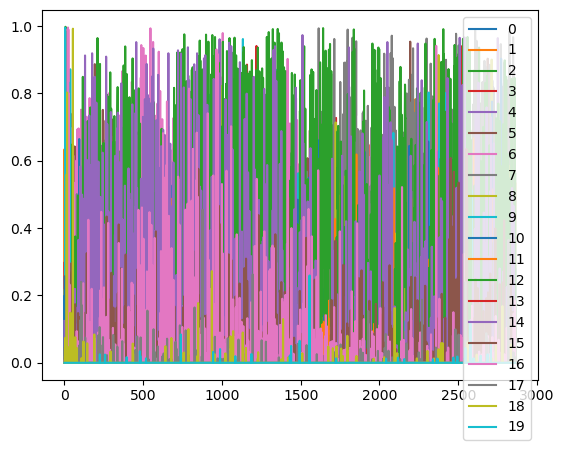

In [52]:
import matplotlib
chapters_topic_matrix.plot()

In [53]:
import plotly
import plotly.express as px
chapters_topic_matrix["doc"] = chapters_topic_matrix.index
chapters_topic_matrix_years = { doc:year for doc, year in enumerate(corpus_chapters_lemmas_year) }
chapters_topic_matrix["year"] = corpus_chapters_lemmas_year
chapters_topic_matrix.head()
chapters_topic_matrix_wide = chapters_topic_matrix.melt(id_vars=["doc","year"],var_name="topic")

In [ ]:
len(corpus_chapters_lemmas_year)

In [54]:
chapters_topic_matrix_wide = chapters_topic_matrix_wide[chapters_topic_matrix_wide["value"] > 0].sort_values(["doc","topic"])
chapters_topic_matrix_wide.head()

doc year topic     value
2863     0    0     1  0.105187
8589     0    0     3  0.296643
20041    0    0     7  0.014269
22904    0    0     8  0.215646
28630    0    0    10  0.197342

In [61]:
lda_model_lemmas_reduced.show_topics()

[(7,
  '0.028*"motus" + 0.011*"subverto" + 0.006*"alveum|alveus" + 0.005*"piscor" + 0.005*"volatus" + 0.005*"everro" + 0.004*"rete" + 0.004*"caverna" + 0.004*"pavor" + 0.003*"decido"'),
 (11,
  '0.136*"gubernator" + 0.017*"comes" + 0.012*"filius" + 0.011*"neu" + 0.011*"alba" + 0.010*"daniel" + 0.010*"nihil" + 0.009*"perhorresco" + 0.009*"emereo" + 0.008*"pertimesco"'),
 (16,
  '0.012*"occido" + 0.010*"hungaria" + 0.009*"quadraginta" + 0.008*"vesper" + 0.008*"alpis" + 0.008*"jungo" + 0.007*"incendium" + 0.007*"mars" + 0.006*"stephanus" + 0.006*"vivus"'),
 (6,
  '0.060*"filius" + 0.059*"filia" + 0.034*"dux" + 0.026*"duco" + 0.026*"uxor" + 0.024*"relinquo" + 0.019*"filia|filius" + 0.019*"imperator" + 0.017*"henricus" + 0.017*"rex"'),
 (19,
  '0.011*"video" + 0.007*"tantus" + 0.007*"quasi" + 0.007*"ignis" + 0.006*"populus" + 0.006*"sacer" + 0.006*"ascendo" + 0.005*"gener|genus" + 0.005*"divinus" + 0.005*"sic"'),
 (13,
  '0.037*"episcopus" + 0.025*"ecclesia" + 0.012*"sanctus" + 0.012*"ioann

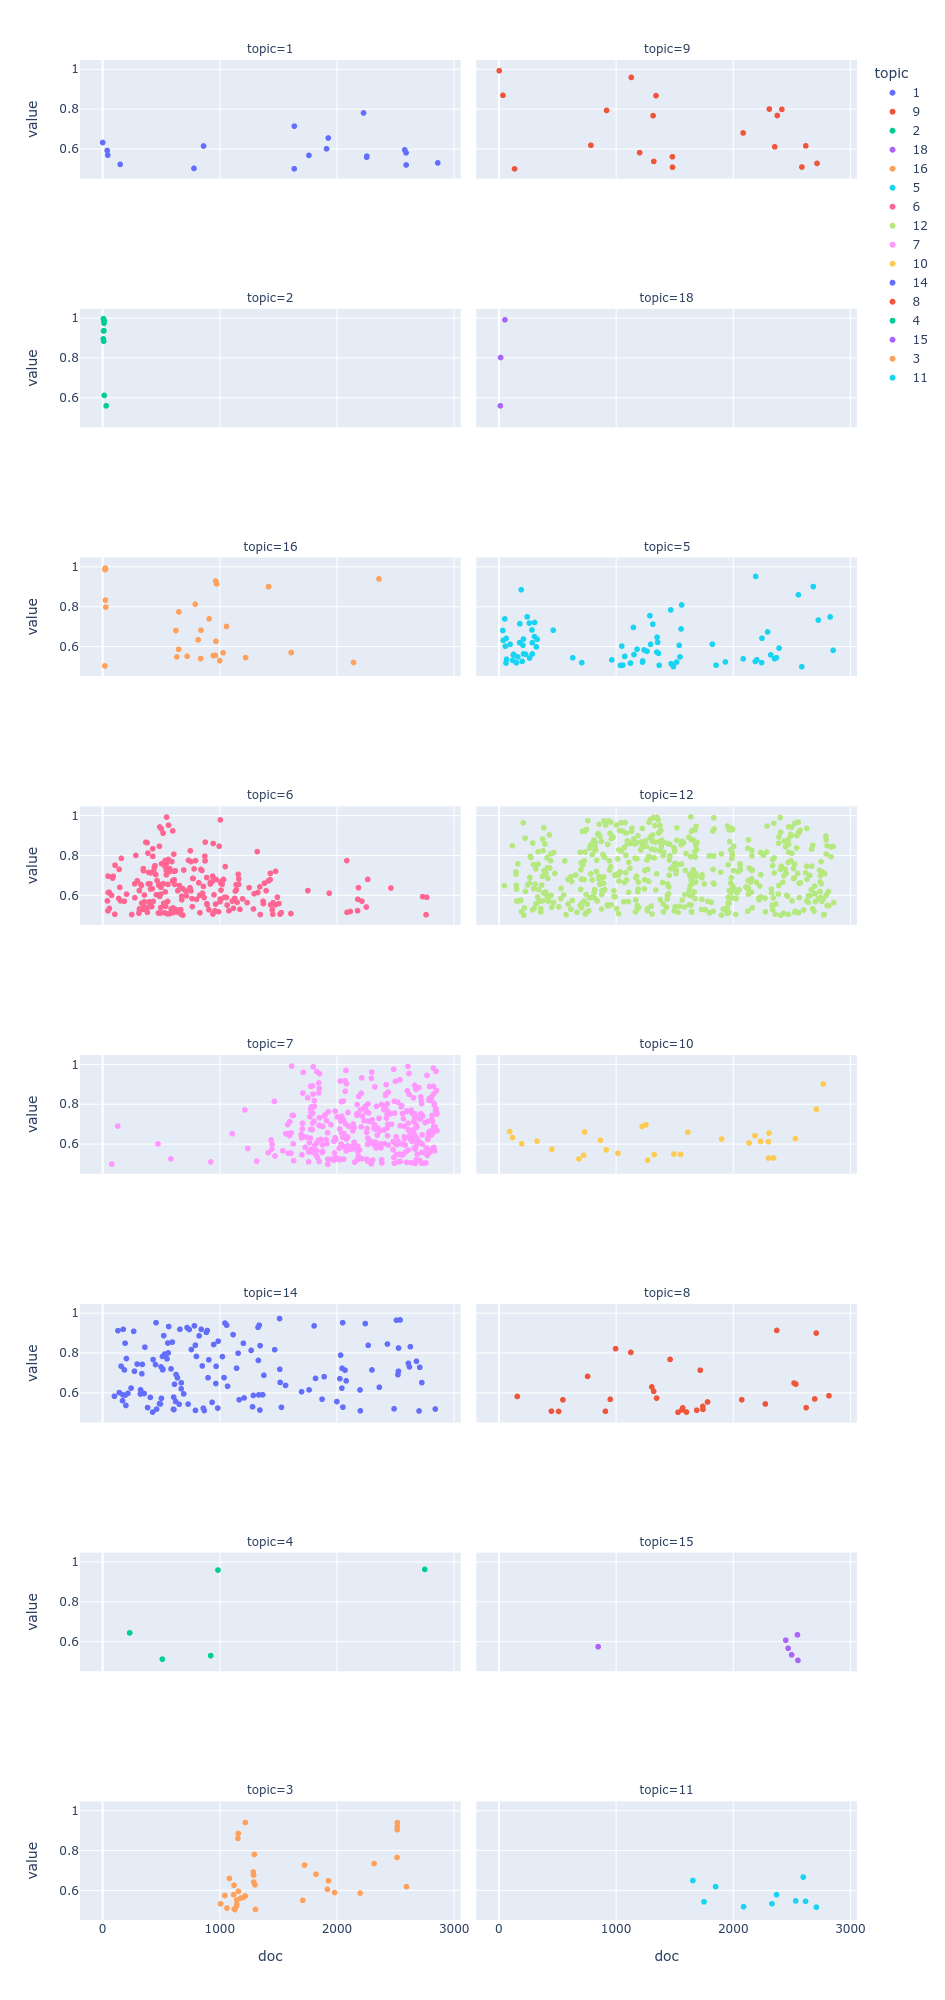

In [55]:
#px.scatter_matrix(chapters_topic_matrix, x="doc", y="value", color=topic)
import plotly
import plotly.express as px
fig = px.scatter(chapters_topic_matrix_wide[chapters_topic_matrix_wide["value"] >0.5], x="doc", y="value",
                 color="topic",
                 #size="value",
                 facet_col="topic", facet_col_wrap=2, height=2000)
#fig.update_layout(yaxis_range=[0.2,1.2])
fig.show()

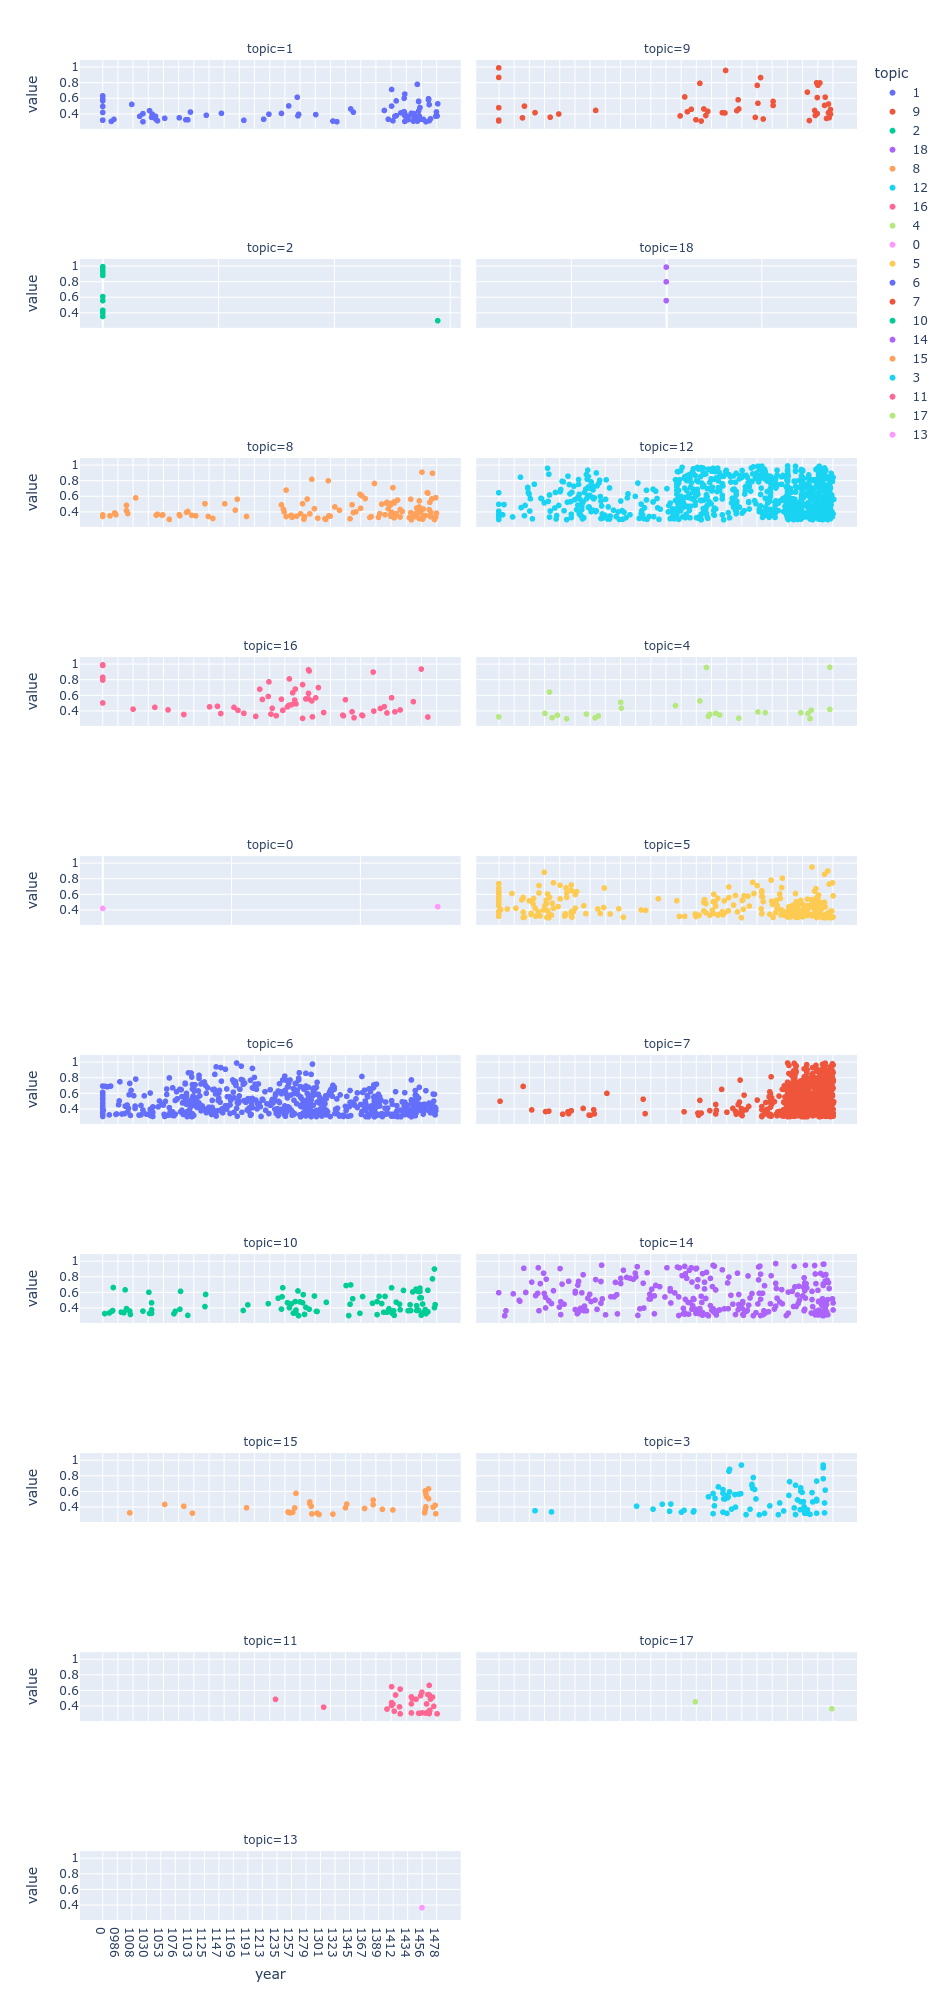

In [56]:
#px.scatter_matrix(chapters_topic_matrix, x="doc", y="value", color=topic)
import plotly
import plotly.express as px
fig = px.scatter(chapters_topic_matrix_wide[chapters_topic_matrix_wide["value"] >0.3], x="year",
                 y="value",
                 color="topic",
                 #size="value",
                 facet_col="topic", facet_col_wrap=2, height=2000)
#fig.update_layout(yaxis_range=[0.2,1.2])
fig.update_xaxes(categoryorder='array', categoryarray= corpus_chapters_lemmas_year)
fig.show()

In [ ]:
import numpy as np
import pandas as pd
topic_sims = []

for similarities in index:
    topic_sims.append(similarities)

In [ ]:
chapters_topic_sim = pd.DataFrame(topic_sims)
chapters_topic_sim.head()

In [ ]:
for row in topic_matrix:
    print(topic_matrix[row] > 0.5)

In [ ]:
for num_topic in num_topics:
    lda_model_lemmas_rednlargested = LdaModel(
        corpus=corpus_chapters_lemmas_reduced_bow,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topic,
        passes=passes,
        eval_every=eval_every
    )
    coherence_model_lda = CoherenceModel(model=lda_model_lemmas_reduced, texts=corpus_chapters_lemmas_reduced, 
                                         dictionary=corpus_chapters_lemmas_reduced_dictionary,
                                         coherence='c_v')
    
    print("topics: " + str(num_topic) ,"coherence: ", coherence_model_lda.get_coherence(), 
          "\tperplexity: ", 
          lda_model_lemmas_reduced.log_perplexity(corpus_chapters_lemmas_reduced_bow)
         )
#best results
#topics: 10 coherence:  0.4043357272535478 	perplexity:  -7.509568616109219
#topics: 20 coherence:  0.45175391591224745 	perplexity:  -7.559552059787899
#topics: 30 coherence:  0.4145315890018234 	perplexity:  -7.603553920253678
#topics: 40 coherence:  0.41797913503984957 	perplexity:  -7.663085551756763
#topics: 50 coherence:  0.3995843728274568 	perplexity:  -7.728750670838585

In [ ]:
pprint.pprint(lda_model_lemmas_reduced)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model_lemmas_reduced, texts=corpus_chapters_lemmas_reduced, 
                                     dictionary=corpus_chapters_lemmas_reduced_dictionary,
                                     coherence='c_v')

print("topics: " + str(20) ,"coherence: ", coherence_model_lda.get_coherence(), 
      "\tperplexity: ", 
      lda_model_lemmas_reduced.log_perplexity(corpus_chapters_lemmas_reduced_bow)
     )

In [ ]:
import pprint
#pprint.pprint(lda_model_lemmas_reduced.print_topics())

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmas_reduced, corpus_chapters_lemmas_reduced_bow, corpus_chapters_lemmas_reduced_dictionary)
vis

In [ ]:
corpus_chapters_lemmas_dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus_chapters_lemmas_bow =  [corpus_chapters_lemmas_dictionary.doc2bow(chapter) 
                      for chapter in corpus_chapters_lemmas
                              ]

# Make an index to word dictionary.
temp = corpus_chapters_lemmas_dictionary[0]  # This is only to "load" the dictionary.
id2word = corpus_chapters_lemmas_dictionary.id2token

for num_topic in num_topics:
    lda_model_lemmas = LdaModel(
        corpus=corpus_chapters_lemmas_bow,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topic,
        passes=passes,
        eval_every=eval_every
    )
    coherence_model_lda = CoherenceModel(model=lda_model_lemmas, texts=corpus_chapters_lemmas, 
                                         dictionary=corpus_chapters_lemmas_dictionary,
                                         coherence='c_v')
    
    print("topics: " + str(num_topic) ,"coherence: ", coherence_model_lda.get_coherence(), "\tperplexity: ", 
          lda_model_lemmas.log_perplexity(corpus_chapters_lemmas_bow))

In [ ]:
#liber year div/chapter,head,p
def check_type(div):
    typeof = 'text'  #p div etc
    if div.tag == "head":
        if "class" in div.attrib.keys():
            if div.attrib["class"] == "annus":
                typeof='annus'
            elif div.attrib["class"] == "chapter":
                typeof='chapter'
            else:
                typeof="head"
        else:
                typeof="head"                
    return typeof

def process_vrt(raw):
    lines = []
    for line in [line for line in raw.split("\n") if line != ""]:
        tok,pos,lem = None, None, None
        cols = line.split('\t')
        if len(cols) == 3:
            tok, pos,lem = cols
        else:
            tok = cols[0]
        lines.append((tok,pos,lem))
    return lines
    #return raw
        
text_dict = {}
#text_dict = {book : {chapter : [{year, typeof, txt}]} }
liber = 0
for el in root: #liber
    year = 0
    chapter = None
    classes = ['head', 'annus', 'text']
    typeof = 'text'
    raw_text = ''
    
    #liber
    if "class" in el.attrib.keys():
        if el.attrib["class"] == 'liber':
            liber = int(el.attrib["n"])
            text_dict[liber] = dict()
            #print("liber",liber)
    for ell in el.getchildren():
        if "class" in el.attrib.keys():
            if ell.attrib["class"] == "year":
                year = ell.attrib["n"]
                #print("year ", year)
                for elll in ell.getchildren():
                    if elll.tag == "head":
                        typeof = check_type(elll)                
                        raw_text = elll.text
                        
                        if chapter is not None:
                            chapter += 1
                        else:
                            chapter = 0
                        
                        text_dict[liber][chapter] = list()
                        text_dict[liber][chapter].append([year, typeof, process_vrt(raw_text)])
                            
                    elif elll.tag == "div":
                        if elll.attrib["class"] == "chapter":
                            if chapter is not None:
                                chapter += 1
                            else:
                                chapter = 0
                            #print("chapter ", chapter)
                            text_dict[liber][chapter] = list()
                            for ellll in elll.getchildren():
                                typeof = check_type(ellll)
                                raw_text = ellll.text
                                #print("chapter ", chapter)                           
                                text_dict[liber][chapter].append([year, typeof, process_vrt(raw_text)])
                                
                                
                    
            #chapters under liber 0-1
            elif ell.attrib["class"] == "chapter":
                if chapter is not None:
                    chapter += 1
                else:
                    chapter = 0
                text_dict[liber][chapter] = list()
                for elll in ell.getchildren():
                    typeof = check_type(elll)
                    raw_text = elll.text
                    text_dict[liber][chapter].append([year, typeof, process_vrt(raw_text)])
                    
                    #print("raw_text ", raw_text)
                    #print("typeof ", typeof)
#print(text_dict[4][5]) #chapter (head, text*) in a single year
#print(type(text_dict))

docs_by_year = [] 
docs_by_liber = []

In [ ]:
docs_by_chapter = [] # list of chapters (liber, chapter, year, tokens)
all_by_chapter= [] #all chaps
txt_chapt_numbers = []
txt_chapt_num_current = []
text_to_all_chapters = {} #{chapter : {liber:chapter}} #only texts
text_dict_joined = {}

i = 0
for liber in text_dict.keys():
    if liber not in text_dict_joined.keys():
        text_dict_joined[liber] = {}
    for chapter in text_dict[liber].keys():
        if chapter not in text_dict_joined[liber].keys():
            text_dict_joined[liber][chapter] = {"year":None}
            
        
        chapter_tokens_txt = []
        chapter_tokens = []
        
        for txt_arr in text_dict[liber][chapter]:
            text_dict_joined[liber][chapter]["year"] = txt_arr[0]
            if txt_arr[1] not in text_dict_joined[liber][chapter].keys():
                text_dict_joined[liber][chapter][txt_arr[1]] = []
            text_dict_joined[liber][chapter][txt_arr[1]].append(' '.join([tok[0] for tok in txt_arr[2]]))
            for tok in txt_arr[2]: #iterates over tokens
                chapter_tokens.append((liber, chapter, txt_arr[0], txt_arr[1], tok[0], tok[1], tok[2])) #liber,chap, year,token
            
            if txt_arr[1] == "text": #exclude head etc.
                if str(liber) + "_" + str(chapter) not in txt_chapt_num_current:
                    txt_chapt_num_current.append(str(liber) + "_" + str(chapter))
                    text_to_all_chapters[i] = {liber:chapter}
                    i+= 1
                for tok in txt_arr[2]: #iterates over tokens
                    chapter_tokens_txt.append((liber, chapter, txt_arr[0], tok[0], tok[1], tok[2])) #liber,chap, year,token
        if len(chapter_tokens_txt) > 0:
            docs_by_chapter.append(chapter_tokens_txt)
        all_by_chapter.append(chapter_tokens)

In [70]:
# corpus files for nltk
import os
nltk_path="src/nltk/"
if not os.path.isdir(nltk_path):
    os.mkdir(nltk_path)

files_by_chapter = []
for i, doc in enumerate(docs_by_chapter):    
    #print(i, doc)
    sents = []
    sent = []
    
    for j,tok in enumerate(doc):
        sent.append(str(tok[3])+'/'+ str(tok[4]) ) #pos tags
        if tok[3] == '.' and len(sent) > 0 or j == len(doc)-1:
            sents.append(sent)
            sent = []
            #print(sent)
    if len(sents) > 0 :
        files_by_chapter.append(sents)   
    

In [71]:
for doc_n, doc in enumerate(files_by_chapter):
    file = os.path.join(nltk_path,str(doc_n)+ ".txt")
    doc_list = [' '.join(l)+"\n" for l in doc]
    with open(file,'w+') as f:
        f.writelines(doc_list)

In [72]:
chapters_nltk_cats= {}
for i in range(0,len(files_by_chapter)):
    chapters_nltk_cats[str(i)+".txt"] = {"chapter":i, 
                                        "year":search_text_chapter(i,"year"),
                                        "liber":search_text_chapter(i,"liber")
                                   }

In [73]:
from nltk.corpus.reader import CategorizedTaggedCorpusReader,TaggedCorpusReader
chapters_nltk = TaggedCorpusReader(root=nltk_path,fileids=r'^\d+.txt')
chapters_nltk_categorized = CategorizedTaggedCorpusReader(cat_map=chapters_nltk_cats,root=nltk_path,fileids=r'^\d+.txt')

In [113]:
def search_text_chapter(ind,what):
    liber, chapter = [(k, text_to_all_chapters[ind][k]) for k in text_to_all_chapters[ind]][0]
    if what == 'liber':
        return liber
    elif what == 'chapter':
        return chapter
    else:
        return text_dict_joined[liber][chapter][what]

In [114]:
search_text_chapter(390,"year")

'1107'

In [115]:
chapters_nltk_categorized.words('1.txt')

['Studiorum', 'meorum', 'labores', ',', ...]

In [2]:
import re
from nltk.probability import ConditionalFreqDist
word_len_cfd = ConditionalFreqDist()
chapter_len_cfd = ConditionalFreqDist()
year_len_cfd = ConditionalFreqDist()
liber_len_cfd = ConditionalFreqDist()
chapters_nltk_categorized.fileids()
chapters_word_length = {"by_year" : {}, "by_chapter" : {}, "by_liber" : {}}
for file in chapters_nltk_categorized.fileids():
    file_id = re.sub(r'\.txt', '', file)
    #print(file_id)
    #print(search_text_chapter(int(file_id), "year"))
    year = search_text_chapter(int(file_id), "year")
    chapter = search_text_chapter(int(file_id), "chapter")
    liber = search_text_chapter(int(file_id), "liber")
    #word_lens = []
    for w in chapters_nltk_categorized.words(file):
        if w not in [';', ',', '.', '-', '"', '?', '!']:
            word_len_cfd[len(w)][w] +=1
            chapter_len_cfd[chapter][len(w)] +=1
            year_len_cfd[year][len(w)] +=1
            liber_len_cfd[liber][len(w)] +=1

NameError: name 'chapters_nltk_categorized' is not defined

In [134]:
%matplotlib widget
#liber_len_cfd.plot()
#year_len_cfd.plot()
chapter_len_cfd.plot()

In [1]:
year_len_cfd.plot(cumulative=True, conditions="year")

NameError: name 'year_len_cfd' is not defined

In [80]:
#word length
chapters_nltk_categorized.categories('chapter')

[]

In [8]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmas, corpus_chapters_lemmas_bow, corpus_chapters_lemmas_dictionary)
vis

ModuleNotFoundError: No module named 'pyLDAvis'

In [ ]:
text_dict[0][2]

In [ ]:
docs_by_chapter[2862]

In [38]:
corpus_chapter_bow = [corpus_chapters_dictionary.doc2bow(chapter) 
                      for chapter in corpus_chapters]

NameError: name 'corpus_chapters_dictionary' is not defined

In [37]:
corpus_chapter_reduced_bow = [corpus_chapters_reduced_dictionary.doc2bow(chapter) 
                      for chapter in corpus_chapters]
#print(corpus_chapter_bow[0:10])
from gensim import models

# train the model
tfidf = models.TfidfModel(corpus_chapter_reduced_bow)

NameError: name 'corpus_chapters_reduced_dictionary' is not defined

In [13]:
# Make an index to word dictionary.
temp = corpus_chapters_lemmas_reduced_dictionary[0]  # This is only to "load" the dictionary.
id2word = corpus_chapters_lemmas_reduced_dictionary.id2token
lda_model_lemmas_reduced = LdaModel(
        corpus=corpus_chapters_lemmas_reduced_bow,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=20,
        passes=passes,
        eval_every=eval_every
    )

NameError: name 'corpus_chapters_lemmas_reduced_dictionary' is not defined

In [14]:
#document similarity - breaks
from gensim import similarities
index = similarities.SparseMatrixSimilarity(tfidf[corpus_chapter_reduced_bow], num_features=12)
query_document = "gallia est omnis diuisa".split()
query_bow = corpus_chapters_reduced_dictionary.doc2bow(query_document)
sims = index[tfidf[query_bow]]
#print(list(enumerate(sims)))

NameError: name 'tfidf' is not defined

In [15]:
# topic modelling
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

NameError: name 'dictionary' is not defined

In [16]:
# lexical richness
from lexicalrichness import LexicalRichness
lex_rich =  LexicalRichness([tok for chap in corpus_chapters for tok in chap ], preprocessor=None, tokenizer=None)

ModuleNotFoundError: No module named 'lexicalrichness'

In [17]:
lex_rich.mtld()

NameError: name 'lex_rich' is not defined

In [18]:
lex_rich.mattr()

NameError: name 'lex_rich' is not defined

In [19]:
lex_rich.vocd_fig()

NameError: name 'lex_rich' is not defined

In [20]:
len([ chap for chap in corpus_chapters ])

NameError: name 'corpus_chapters' is not defined

In [21]:
corpus_chapters[0]

NameError: name 'corpus_chapters' is not defined

In [22]:
corpus_chapters[0]

NameError: name 'corpus_chapters' is not defined

In [390]:
a = CorpusFromList()

TypeError: CorpusReader.__init__() missing 2 required positional arguments: 'root' and 'fileids'

In [ ]:
#TODO
#keywords: https://radimrehurek.com/gensim/similarities/termsim.html
#formularność: ngrams
#stylistics?